# Latent Dirichlet Allocation

# 1 Abstract

  Latent Dirichlet allocation(LDA) is a generative topic probabilistic model first proposed by  David M.Blei, Andrew Y.Ng, and Michae l. Jordan to find latent topics in a text corpus. 

  This algorithm is a three-level hierarchical Bayesian model. It has three basic concepts: word, topic, and document. Actually, LDA mimics the method of human write an article and uses the process to reverse inference the distribution of topics when we have an article.Variational Inference is used for approximating intractable integrals arising in a Bayesian network. Therefore, in the inference steps, variational Inference can be seen as an extension of the EM algorithm which computes the entire posterior distribution of latent variables. In the meanwhile, LDA uses Newton-Raphson method and gradient descent to calculate the minimum of a lower bound. Also, the Hessian matrix is necessary for gradient descent procedures.


  In this report, we described, analyzed and mathematically implemented the LDA model. And then implement all the core functions in LDA algorithm. Additionally, we used Spark to optimize the functions. Finally, a simulation data was used to test the accuracy of our functions.





# 2 Background

## 2.1 Bayesian Model
prior + likelihood = posterior


## 2.2 Dirichlet distribution and Multinomial distribution

Conjugate distribution intro....
$$
multi(m_1,m_2,m_3\mid n, p_1,p_2,p_3) = \frac{n!}{m_1!m_2!m_3!}p_1^{m_1}p_2^{m_2}p_3^{m_3}
$$

$$
Dirichlet(p_1,p_2,p_3\mid \alpha_1,\alpha_2,\alpha_3) = \frac{\Gamma(\alpha_1+\alpha_2+\alpha_3)}{\Gamma(\alpha_1)\Gamma(\alpha_2)\Gamma(\alpha_3)}p_1^{\alpha_1-1}p_2^{\alpha_2-1}p_3^{\alpha_3-1}
$$

For higher dimension, we have

$$
Dirichlet(\vec{p}\mid \vec{\alpha}) = \frac{\Gamma(\sum_{k=1}^K\alpha_k)}{\prod_{k=1}^K\Gamma(\alpha_k)}\prod_{k=1}^K
p_k^{\alpha_k-1}$$

With the same conjugate relationship, we have:

$$
Dirichlet(\vec{p}\mid\vec{\alpha})+Multi(\vec{m}) = Dirichlet(\vec{p}\mid\vec{\alpha}+\vec{m})
$$

And the expectation of Dirichlet distribution is:

$$
E(Diri(\vec{p}\mid\vec{\alpha}) = \left( \frac{\alpha_1}{\sum_{k=1}^K\alpha_k},\frac{\alpha_2}{\sum_{k=1}^K\alpha_k},...\frac{\alpha_K}{\sum_{k=1}^K\alpha_k}  \right)
$$

# 3 LDA Model

  We use the language of text collections throughout the paper, referring to entities such as “words,” “documents,” and “corpora.”(p995) Our goal is to find the topic dictribution of each document and the word distribution of each topic. Also, if we are given a new document, we need to use some parameters trained from our model, to inference the topic of taht new document.
  
  To mimic the process of human wrinting an article, the author always needs to have some fixed topics and then uses words withch are strongly related with those topics. So when it comes to machine learning, we also pretend that we need to have the topic at first and then we can generate words under that topic.

To describe the algorithm in an aesier way to understanding, we can treat distribution as a multi-sided dice, each side represents a topic(word), the probabilities of being up of each side are defferent. Added Bayesian idea, the LDA algorihm can be showed as:
- There are two big boxes, one is full of "doc-topic" dices, and another box is full of "topic-word" dices.
- Pick $K$ "topic-word" dices from the second box, label tham as $1,2,...,K$.
- For each document, we pick one "doc-topic" dice from the first box and repeat followings to get words:
   - through this dice, obtain the topic $z$
   - chooes the "doc-topic" dice whose lable is $z$ and through it, then we can obtain one word
   
   
In other words, LDA algorithm assumes the following generative process for each document $\overrightarrow{w}$:

1. Choose $N \sim Poisson(\xi)$
2. Choose $\theta \sim Dir(\alpha)$
3. For each of the $N$ words $w_n$:

    (a). Choose a topic $z_n \sim Multi(\theta)$
    
    (b). Choose a word $w_n$ from $p(w_n\mid z_n, \beta)$, a multinomal probability conditioned on th etopic $z_n$.
    




## 3.1 Mathematical analysis

First of all, let's define some terms which will use in the following text:

$\cdot$ $D$(a corpus) is the collection of $M$ documents;

$\cdot$ $V$ is the total number of words from a vocabulary;

$\cdot$ $M$ is the number of documents;

$\cdot$ $K$ is number of topics of the corpus;

$\cdot$ $N_m$ is the number of words in the $m^{th} document$;

$\cdot$ $w_{mn}$ is the  $n^{th}$ word in docuent $m$; 

$\cdot$ $z_{mn}$ is the topic of word $w_{mn}$;

$\cdot$ $\theta_m$ is the distribution for document $m$;

$\cdot$ 


LDA assumes that the prior distribution of topics is a Dirichlet distribution, i.e., for any document $d$, the distribution of its topic is

$$
\theta_d = Dirichlet(\vec{\alpha})
$$

where $\alpha$ is a K-dimension vector.

A k-dimensional Dirichlet random variable $\theta$ can take values in the $(k-1)$-simplex (a $k$-vector  lies in the $(k-1)$-simplex if $\theta_i \geq 0, \sum_{i=1}^k \theta_i=1$), and has the following probability density on the simplex:
$$
p(\theta\mid \alpha) = \frac{\Gamma(\sum_{i=1}^k \alpha_i)}{\prod_{i=1}^k\Gamma(\alpha_i)}\theta_1^{\alpha_1-1}...\theta_k^{\alpha_k-1}
$$

Given the parameters $\alpha$ and $\beta$, the joint distribution of a topic mixture $\theta$, a set of $N$ topics $\textbf{z} = (z_1, z_2,...z_N)$ and a set of $N$ words $\textbf{w} = (w_1, w_2,...w_N)$ is given by:
$$
p(\theta, \textbf{z},\textbf{w}\mid \alpha, \beta) = p(\theta\mid\alpha)\prod_{n=1}^Np(z_n\mid \theta)p(w_n\mid z_n,\beta)
$$

Integrating over $\theta$ and summing over $z$, we obtain the marginal distribution of a document $\textbf{w}$:
$$
p(\textbf{w}\mid \alpha, \beta) = \int p(\theta\mid\alpha)\prod_{n=1}^N \sum_{z_n} p(z_n\mid \theta)p(w_n\mid z_n,\beta)d\,\theta
$$

Finally, taking the product of the marginal probabilities of single documents, we obtain the probability of a corpus $\textbf{D} = (\textbf{w}_1, \textbf{w}_2,...\textbf{w}_M)$:
$$
\begin{aligned}
p(\textbf{D}\mid \alpha,\beta) &= \prod_{d=1}^M p(\textbf{w}_d\mid \alpha,\beta)\\
&= \prod_{d=1}^M \int p(\theta_d\mid\alpha) \prod_{n=1}^{N_d} \sum_{z_{dn}} p(z_{dn}\mid \theta)p(w_{dn}\mid z_{dn},\beta)d\,\theta_d
\end{aligned}
$$

## 3.2 Variational inference (E-step)

### Parameter declaration

v: vocabulary, $v = 1,2,...,V$

z: topic , $z = 1,2,...,K$

m: document, $m = 1,2,...,M$

w: word, $w =1,2,...N_1, N_1+1, ...N_1+N_2,...,\sum_{m=1}^NN_m$ 

$\alpha$: a $K$ dim vector, represents the topic distribution of $K$ topics

$\beta$: a $K\times V$ matrix, $\beta_{ij}$ represents probability of the $j^{th}$ word of $i^{th}$ topic.

$\phi$: a $M\times N \times K$ matrix, where $N = \sum_{m=1}^NN_m$, represents probability of each topic for words in each document

$\gamma$: a $M\times K$ matrix, represents the probability of topic for each document



### Inference

We need to compute the posterior distribution of hidden variables:

$$
p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta) = \frac{p(\theta, \textbf{z}, \textbf{w}\mid \alpha, \beta)}{p(\textbf{w}\mid \alpha, \beta)}
$$

But this distribution is intractable due to the coupling between $\theta$ and $\beta$.
So we use the variation distribution on latent variables:

$$
q(\theta, \textbf{z}\mid \gamma, \phi) = q(\theta\mid \gamma)\prod_{n=1}^N q(z_n\mid \phi_n)
$$

An optimization problem that determins the values of $\gamma$ and $\phi$ with respect to KL-Divergence:

$$
(\gamma^*, \phi^*) = arg\ \underset{\phi, \gamma}{min}\,D(q(\theta, \textbf{z}\mid \gamma, \phi)||p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta))
$$

Then we denote $q(\theta, \textbf{z}\mid \gamma, \phi)$ by $q$, the KL-Divergence between $q$ and $p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta)$ is

$$
\begin{aligned}
D(q||p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta)) &= E_q[log\,q]-E_q[log\,p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta)]\\
&=E_q[log\,q]-E_q[log\,p(\theta, \textbf{z}, \textbf{w}\mid \alpha, \beta)]+log\,p(\textbf{w}\mid \alpha, \beta)
\end{aligned}
$$

Using Jensen's inequality, we have the bound as $log\,p(\textbf{w}\mid \alpha, \beta)\geq E_q[log\,p(\theta, \textbf{z},\textbf{w}\mid \alpha, \beta)]-E_q[log(\theta, \textbf{z})]$. And by denoting $E_q[log(\theta, \textbf{z}, \textbf{w}\mid \alpha, \beta)] - E_q[log\,q(\theta, \textbf{z})]$ by $L(\gamma, \phi; \alpha, \beta)$, we have

$$
log\,P(\textbf{w}\mid \alpha, \beta) = L(\gamma, \phi; \alpha, \beta)+D(q(\theta, \textbf{z}\mid \gamma, \phi)||p(\theta, \textbf{z}\mid \textbf{w}, \alpha, \beta))
$$

So minimizeing the KL-Divergence $D$ is equivalent to maximizing likelihood $L$, then we need to maximize the following five parts one by one:

$$
L(\gamma, \phi;\alpha, \beta) = E_q[log\,p(\theta\mid \alpha)]+E_q[log\,p(\textbf{z}\mid\theta)]+E_q[log\,p(\textbf{w}\mid\textbf{z},\beta)]-E_q[log\,q(\theta)-E_q[log\,q(\textbf{z})]]
$$

Finally, by computing the derivatives of $L$ and set them equals to 0, we obtain update equations:

$$
\begin{aligned}
\phi_{ni}&\propto \beta_{iv}\,exp\{\psi(\gamma_i)-\psi(\sum_{j=1}^K\gamma_j)\}\\
\gamma_i &= \alpha_i+\sum_{n=1}^N\phi_{ni}
\end{aligned}
$$
where $\psi$ is the digamma function, the first derivative of the log Gamma function.

### Variational Inference Algorithm

- initialize $\phi_{ni}^0 = \frac{1}{K}$ for all $i$ and $n$.
- initialize $\gamma_i^0 = \alpha_i+\frac{N}{K}$ for all $i$.
- repeat
    - for $n = 1$ to $N$
    - for $i = 1$ to $K$
         - $\phi_{ni}^{t+1} = \beta_{iw_n}\,exp\{\psi(\gamma_i^t)\}$.
         - normalize $\phi_{ni}^{t+1}$ to sum 1.
    - $\gamma^{t+1} = \alpha+\sum_{n=1}^N \phi_n^{t+1}$.
- until convergence



In [2]:
import numpy as np
from scipy.special import digamma, polygamma

In [103]:
# convergence function
def is_convergence1(old, new, tol = 10**(-2)):
    """
    output:
    TRUR or FALSE
    """
    loss = np.sqrt(list(map(np.sum,np.square(old - new))))
    return np.max(loss) <= tol

def is_convergence2(old, new, tol = 10**(-2)):
    """
    output:
    TRUR or FALSE
    """
    loss = np.sqrt(np.sum(np.square(old - new)))
    return np.max(loss) <= tol

def optimize_vp(phi, gamma, alpha, beta, words, M, N, K, max_iter=500):
    '''
    optimize the variational parameter
    
    Parameters
    ----------
    phi:   ndarray
           An array of topic-word matrix
    gamma: ndarray
           A matrix of doc-topic
    alpha: ndarray
           the parameter of doc-topic dirichlet distribution
    beta:  ndarray
           the parameter of topic-word dirichlet distribution
    words: list 
           the list of lists of words in all 
    M : int, the number of documents
    N : ndarraay, the number of words in each document
    K : int, the number of topics in the corpus
    Returns
    -------
    out : list of ndarray
          the optimized and normalized(sum to 1) phi 
    '''
    
    for t in range(max_iter):
        phi_old = phi
        gamma_old = gamma
        #update phi
        for m in range(M):
            for n in range(N[m]):
                for i in range(K):
                    phi[m][n,i] = beta[i,np.int(words[m][n])] * np.exp(digamma(gamma[m,i]))
                #nomalize to 1
                phi[m][n,:] = phi[m][n,:]/np.sum(phi[m][n,:])
        phi_new = phi
        #update gamma
        for i in range(M):
            gamma[i,:]  = alpha + np.sum(phi[i], axis = 0)
        gamma_new = gamma
        
        if is_convergence1(phi_old, phi_new) == True and is_convergence2(gamma_old, gamma_new) == True:
            break
   
    return phi, gamma

##  3.3 Parameter estimation (M-step)

Now, given a corpus of documents $\textbf{D} = (\textbf{w}_1, \textbf{w}_2,...\textbf{w}_M)$, we hope to find proper parameters. So, in this M-step, maximize the bound with respect to the model parameters $\alpha$ and $\beta$.

Firstly, we maximize $L(\gamma, \phi;\alpha,\beta)$ with respect to $\beta$, by taking the derivative with respect to $\beta_{ij}$ and setting it to zero, we have:

$$
\beta_{ij}\propto \sum_{m=1}^M\sum_{n=1}^{N_m}\phi_{m,n,i}w_{mn}^j
$$

here we need to attention that $\beta$ is a probability matrix whose rows represent words probability of one particular topic, so the sum of each rows should equal one.

Secondly, we maximize $L(\gamma, \phi;\alpha,\beta)$ with respect to $\alpha$, and then take the derivative with respect to $\alpha_i$. However, it is difficult to compute $\alpha_i$ by setting the derivative to zero:

$$
\frac{\partial L}{\partial \alpha_i} = M\left(\psi(\sum_{j=1}^K \alpha_i)-\psi(\alpha_i)\right)+\sum_{m=1}^M \left(\psi_{mi}-\psi\left(\sum_{j=1}^K \gamma_{mj}\right)\right):=g_i
$$

Because this derivative depends on $\alpha_i$, where $j\neq i$. So we need to use an iterative method (eg. Newton-Raphson method) to find the extreme point. Then we can compute the Hessian Matrix as:

$$
\frac{\partial^2L}{\partial \alpha_i\partial\alpha_j} = -\delta(i,j)M\psi'(\alpha_i) +M \psi'\left(\sum_{j=1}^K \alpha_i\right):=H_{ij}
$$

Finally, we only need to use Newton-Raphson methods to update $\alpha$ and obtain the answer when converge. The Newton-Raphson optimization technique finds a stationary point of a function by iterating

$$
\alpha_{new} = \alpha_{old}-H(\alpha_{old})^{-1}g(\alpha_{old})
$$

where $H(\alpha)$ is the Hessian matrix and $g(\alpha)$ is the gradient vector.
If the Hessian matrix is of form $H = diag(h)+\textbf{1}\,z\,\textbf{1}^T$, then we can culculate that

$$
(H^{-1}g)_i = \frac{g_i-c}{h_i}\\
c = \frac{\sum_{j=1}^K g_j/h_j}{z^{-1}+\sum_{j=1}^K h_j^{-1}}
$$

In [104]:
# estimate alpha
def alpha_estimate(gamma, alpha_initial, K, M, max_iter = 100):
    """
    This is an estimation function, especially used in the process of LDA algorithm.
    digamma function and polygamma function are used in the following process.
    
    input:
    alpha_initial: the initial setting of alpha, it is an 1*K vector
    K: the number of topics
    M: the number of documents
    gamma: the result from another update function (see gamma_update())
    """
    from scipy.special import digamma, polygamma
    
    alpha = alpha_initial
    for t in range(max_iter):
        alpha_old = alpha
        
        # compute the gradient vector and the diagonal part of the Hessian matrix
        g = np.zeros(K)
        h = np.zeros(K)
        for i in range(K):
            g1 = M*(digamma(np.sum(alpha))-digamma(alpha[i]))
            g2 = 0
            for d in range(M):
                g2 += digamma(gamma[d,i])-digamma(np.sum(gamma[d,:]))
            g[i] = g1 + g2
            
            h[i] = -M*polygamma(1, alpha[i])
        
        # compute the constant part
        z = M*polygamma(1, np.sum(alpha))
        c = (np.sum(g/h))/(z**(-1) + np.sum(h**(-1)))
                           
        # update alpha                   
        alpha -= (g-c)/h
        
        if is_convergence2(alpha_old, alpha):
            break
            
    return alpha

In [105]:
# estimate beta
def beta_estimate(K, V_words, phi, D):
    
    """
    This is an estimation function, especially used in the process of LDA algorithm
    
    input:
    K: the number of topics
    V_words: a vector of all unique words in the vocabulary
    D: D = (w_1,w_2,...w_M), contains all words in all documents
    phi: the result from another update function (see phi_update())
    
    output:
    beta: the estimate parameter for LDA, it is a K*V matrix
    """
    V = len(V_words)
    beta = np.ones((K,V))
    # first obtain the propotion values
    for j in range(V):
        word = V_words[j]
        # give a TRUE or FALSE "matrix", remember w_mnj should have the same shape with phi
        w_mnj = [np.repeat(w==word, K).reshape((len(w),K)) for w in D]
        # compute the inner sum over number of words
        sum1 = list(map(lambda x: np.sum(x,axis=0),phi*w_mnj))
        # compute the outer sum over documents
        beta[:,j] = np.sum(np.array(sum1), axis = 0)
    
    # then normalize each row s.t. the row sum is one
    for i in range(K):
        beta[i,:] = beta[i,:]/sum(beta[i,:])
        
    return beta

## 3.4 Combination (Variational EM)

After the procedures above, now we can combine all the algorithms into a summary:

1. (E-step) For each document, find the optimizing values of the variational parameters ${\gamma_d^*, \phi)d^*:\,d\in D}$. This is done as described in the previous section.

2. (M-step) Maximize the resulting lower bound on the log likelihood with respect to the model parameters $\alpha$ and $\beta$. This corresponds to finding maximum likelihood estimates with expected sufficient statistics for each document under the approximate posterior which is computed in the E-step.

These two steps are repeated until the lower bound on the log likelihood converges.


### (1) input:
- K: the number of topics
- M: the number of documents
- D: contains all words of documents

### (2) initialize $\alpha$ and $\beta$

### (3) start EM algorithm:
- Use variational inference algorithm to update $\gamma$ and $\phi$:
- (1). initialize $\phi_{ni}^0 = \frac{1}{K}$ for all $i$ and $n$.
- (2). initialize $\gamma_i^0 = \alpha_i+\frac{N}{K}$ for all $i$.

   - repeat
   - for $n = 1$ to $N$
   - for $i = 1$ to $K$
       - $\phi_{ni}^{t+1} = \beta_{iw_n}\,exp\{\psi(\gamma_i^t)\}$.
       - normalize $\phi_{ni}^{t+1}$ to sum 1.
   - $\gamma^{t+1} = \alpha+\sum_{n=1}^N \phi_n^{t+1}$.
   - until convergence
     
- Use parameter estimation to estimate $\alpha$ and $\beta$:
   - use the converged $\phi$ and $\gamma$ to update
   - until convergence
   
### (4) when all parameters ocnvergede, break.

### (5) output posterior parameters $\alpha$ and $\beta$, end.

In [106]:
# Variation EM
def variation_EM(M, K, D, N, V_words, alpha_initial, beta_initial, gamma_initial, phi_initial, iteration = 1000):
    
    phi_gamma = optimize_vp(phi_initial, gamma_initial, alpha_initial, beta_initial, w_struct, M, N, K)
    phi = phi_gamma[0]
    gamma = phi_gamma[1]
    
     
    (alpha, beta) = (alpha_initial, beta_initial)
    
    for t in range(iteration):
        
        (phi_old, gamma_old) = (phi, gamma)
        
        alpha = alpha_estimate(gamma, alpha, K, M)
        beta = beta_estimate(K, V_words, phi, D)
        
        phi_gamma1 = optimize_vp(phi, gamma, alpha, beta, w_struct, M, N, K)
        phi = phi_gamma1[0]
        gamma = phi_gamma1[1]
        
        if is_convergence2(gamma_old, gamma) and is_convergence1(phi_old, phi):
            break
    
    return alpha, beta, gamma, phi

# 4 Optimization

## 4.1 Algorithm optimization
Now we hope to improve our functions in order to speed up. When look back at the algorithm, we find there are some places that can be replaced by other optimal methods.


### Normalize $\phi$
Firts of all ,we notice that in the process of updating $\phi$'s we need to normalize them. There is a famous tip which focuses on the transformation between "log" and "sum". In other words, we can use $log(a)$ and $log(b)$ to calculate $log(a+b)$:

$$
\begin{aligned}
log(a+b) &= log\left(a\times (1+\frac{b}{a})\right)\\
&=log(a)+log\left(a+\frac{b}{a}\right)\\
&= log(a)+log\left(1+e^{log(b)-log(a)}\right)
\end{aligned}
$$

So in normalization, this method can add in pairs during each iteration after geting $log(\phi_1), log(\phi_2),...,log(\phi_K)$ and finally speed up the summation of $log(\phi_1+\phi_2+...+\phi_K)$. And then use the following equation to realize normalization:

$$
\phi_i = \frac{\phi_i}{\phi1+\phi_2+...+\phi_K}\\
\Rightarrow log(\phi_i) = \log(\phi_i)-\log(\phi_1+\phi_2+...+\phi_K)
$$

Alos, because of the target value has become $log(\phi_1)$, the iterative formula of $\phi$ should be changed into:

$$
log(\phi_{dni}^{t+1}) = log(\beta_{i,w_n})+\psi(\gamma_{di}^t)
$$

### Update $\gamma$

After obtaining $\phi_{ni}$, we find another method to obtain $\gamma_i$ in an easier way.

$$
\begin{aligned}
\gamma_i^0 &= \alpha_i+\frac{N}{K}\\
\gamma_i^{t+1} &= \alpha_i+\sum_{n=1}^N \phi_{dn}^{t+1}\\
&=\alpha_i+\sum_{n=1}^N (\phi_n^{t}+\bigtriangleup \phi_{dn}^{t+1})\\
&=(\alpha_i+\sum_{n=1}^N \phi_n^{t})+\sum_{n=1}^N\bigtriangleup \phi_{dn}^{t+1})\\
&=\gamma_i^t+\sum_{n=1}^N\left(\phi_{dn}^{t+1}-\phi_{dn}^{t}\right)
\end{aligned}
$$

Therefore, we can use only $\gamma^t$, $\phi^t$ and $\phi^{t+1}$ to calculate a new $\gamma^{t+1}$, without using $\alpha$. This can be explained by the truth that we have taken account of $\alpha$ in the initialization step, the information of $\alpha$ has been included in $\gamma$. 

### Vectorizing loops

In our original codes, there are many for loops which may cause a slow computing. However, vectors are a great helper. We will implement this method in functions of eatimating $\alpha$ and $\beta$.

In [ ]:
# a new function to calculate log of sum
def log_sum(log_a, log_b):
    """
    input: log(a), log(b)
    output: log(a+b)
    """
    return log_a + np.log(1+np.exp(log_b - log_a))



def optimize_vp_opt(phi, gamma, alpha, beta, words, M, N, K, max_iter=500):
    '''
    optimize the variational parameter
    
    Parameters
    ----------
    phi:   ndarray
           An array of topic-word matrix
    gamma: ndarray
           A matrix of doc-topic
    alpha: ndarray
           the parameter of doc-topic dirichlet distribution
    beta:  ndarray
           the parameter of topic-word dirichlet distribution
    words: list 
           the list of lists of words in all 
    M : int, the number of documents
    N : ndarraay, the number of words in each document
    K : int, the number of topics in the corpus
    Returns
    -------
    out : list of ndarray
          the optimized and normalized(sum to 1) phi 
    '''
    
    for t in range(max_iter):
        phi_old = phi
        
        # we use log(phi) here and following processes
        log_phi = np.array(list(map(np.log, phi)))
        gamma_old = gamma
       
        for m in range(M):
            for n in range(N[m]):
                
                logsum = 0
                for i in range(K):
                    
                    # use new method in log form to update phi
                    log_phi[m][n,i] = np.log(beta[i,np.int(words[m][n])]) + digamma(gamma[m,i])
                    
                    logsum = log_sum(logsum, log_phi[m][n,i])
                # use new metohd to implement nomalization
                log_phi_mn = log_phi[m][n,:] - logsum
                log_phi[m][n,:] = log_phi_mn
                
                phi[m][n,:] = np.exp(log_phi_mn)
        
            # instead of alpha, use old phi and new phi to iterative
            d_phi = phi[m] - phi_old[m]
            gamma[m,:]  = gamma[m,:] + np.sum(d_phi, axis = 0)
            
        phi_new = phi
        gamma_new = gamma
        
        if is_convergence1(phi_old, phi_new) == True and is_convergence2(gamma_old, gamma_new) == True:
            break
   
    return phi, gamma


In [ ]:

# estimate alpha
def alpha_estimate_opt(gamma, alpha_initial, K, M, max_iter = 100):
    """
    This is an estimation function, especially used in the process of LDA algorithm.
    digamma function and polygamma function are used in the following process.
    
    input:
    alpha_initial: the initial setting of alpha, it is an 1*K vector
    K: the number of topics
    M: the number of documents
    gamma: the result from another update function (see gamma_update())
    """
    from scipy.special import digamma, polygamma
    
    alpha = alpha_initial
    for t in range(max_iter):
        alpha_old = alpha
        
        # we use vector instead of calculating in loop
        g = M*(digamma(np.sum(alpha))-digamma(alpha)) 
        + np.sum(digamma(gamma) -np.tile(digamma(np.sum(gamma,axis=1)),(K,1)).T,axis=0)
        h = -M*polygamma(1,alpha)
        
        z = M*polygamma(1, np.sum(alpha))
        c = (np.sum(g/h))/(z**(-1) + np.sum(h**(-1)))
                           
        # update alpha                   
        alpha -= (g-c)/h
        
        if is_convergence2(alpha_old, alpha):
            break
            
    return alpha



In [142]:
# estimate beta
def beta_estimate_opt(K, V_words, phi, D):
    
    """
    This is an estimation function, especially used in the process of LDA algorithm
    
    input:
    K: the number of topics
    V_words: a vector of all unique words in the vocabulary
    D: D = (w_1,w_2,...w_M), contains all words in all documents
    phi: the result from another update function (see phi_update())
    
    output:
    beta: the estimate parameter for LDA, it is a K*V matrix
    """
    V = len(V_words)
    beta = np.ones((K,V))
    # first obtain the propotion values
    for j in range(V):
        word = V_words[j]
        # give a TRUE or FALSE "matrix", remember w_mnj should have the same shape with phi
        w_mnj = [np.repeat(w==word, K).reshape((len(w),K)) for w in D]
        # compute the inner sum over number of words
        sum1 = list(map(lambda x: np.sum(x,axis=0),phi*w_mnj))
        # compute the outer sum over documents
        beta[:,j] = np.sum(np.array(sum1), axis = 0)
    
    # then normalize each row s.t. the row sum is one, in vector method
    beta= beta/ np.sum(beta, axis = 1).reshape((-1,1))
        
    return beta


## 4.2 JIT optimization

In [149]:
from ipyparallel import Client

In [150]:
rc = Client()
dv = rc[:]

In [152]:
with dv.sync_imports():
    import numba
    import numpy as np
    import random

@numba.jit



importing numba on engine(s)
importing numpy on engine(s)
importing random on engine(s)


# 5 Experimental test

### Simulating Data

Now we'd like to check whether our implementation is correct and whteher the whole functions can give an appropriate reslut. So we generate a set of data which contains 520 documents. And in each document, the number of words is in the range from 100 to 300. We assume the number of topics is 6. In order to visualize the distribution much clearer, we would devide the 520 documents into 6 parts, each parts has the same preference of pair topics. 

$$
\textbf{D} = \{ (\textbf{w}_1,...\textbf{w}_{90}), (\textbf{w}_{91},...\textbf{w}_{180}), (\textbf{w}_{181},...\textbf{w}_{270}), (\textbf{w}_{271},...\textbf{w}_{360}), (\textbf{w}_{361},...\textbf{w}_{450}), (\textbf{w}_{451},...\textbf{w}_{520}) \}
$$

$$
Topics = \{(1,2),(2,3),(3,4),(4,5),(5,6),(6,1)\}
$$

$$
Vocabulary = \{a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,\\
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z\}
$$

In [110]:
np.random.seed(180422)

M = 520
K = 6
V_word =  np.array(list([chr(i) for i in range(97,123)]) + list([chr(i) for i in range(65,91)]))
N = np.random.randint(100,300,size=M)
V = len(V_word)

In [138]:
np.random.seed(180)

# generate probability distribution for six types of topic preferences
alpha = np.fromfunction(lambda i,j: np.where((i-j==-1) | (i==j), np.random.randint(15, 30, 6), 1), (6,6), dtype = 'int')
alpha[5,0] = np.random.randint(15, 30)
beta_preference = (np.ones((K, V)) + np.array([np.arange(V)%K==i for i in range(K)])*10)/16
beta_true = np.array(list(map(lambda x: np.random.dirichlet(x),beta_preference.T))).T


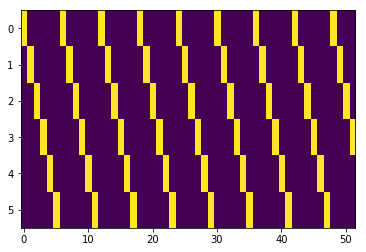

In [139]:
plt.imshow(beta_preference, interpolation='nearest', aspect='auto')
pass

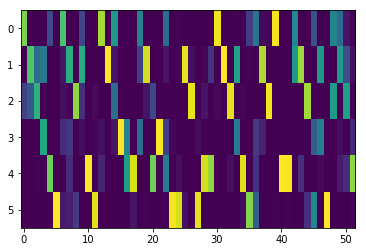

In [140]:
import matplotlib.pyplot as plt
plt.imshow(beta_true, interpolation='nearest', aspect='auto')
pass

### Initialing parameters

In [85]:
np.random.seed(1337)

M = 300
k = 10
N = np.random.randint(150,200,size=M)
V = 30

# Create 3 groups of documents, each with a topic preference
alpha_gen1 = np.array((20,15,10,1,1,1,1,1,1,1))
alpha_gen2 = np.array((1,1,1,10,15,20,1,1,1,1))
alpha_gen3 = np.array((1,1,1,1,1,1,10,12,15,18))

# Arbitrarily choose each topic to have 3 very common words
beta_probs = np.ones((V,k)) + np.array([np.arange(V)%k==i for i in range(k)]).T*19
beta_gen = np.array(list(map(lambda x: np.random.dirichlet(x),beta_probs.T))).T

w_struct = list();
theta = np.empty((M,k))

# Generate each document
for m in range(M):
    # Draw topic distribution for the document
    if m<M/3:
        theta[m,:] = np.random.dirichlet(alpha_gen1,1)[0]
    elif m<2*M/3:
        theta[m,:] = np.random.dirichlet(alpha_gen2,1)[0]
    else:
        theta[m,:] = np.random.dirichlet(alpha_gen3,1)[0]
    doc = np.array([])
    
    for n in range(N[m]):
        # Draw topic according to document's topic distribution
        z_n = np.random.choice(np.arange(k),p=theta[m,:])
        # Draw word according to topic
        w_n = np.random.choice(np.arange(V),p=beta_gen[:,z_n])
        doc = np.append(doc,w_n)
    w_struct.append(doc)